# 0. 영화리뷰 텍스트 감성분석하기

네이버 영화리뷰의 텍스트를 감성분석해보자(긍정 부정 분류)

# 1. 데이터 준비와 확인

이 프로젝트를 진행하기 위해서는 konlpy.tag의 Mecab 함수가 필요한데  
로컬에서 평범하게 kolnpy 라이브러리를 설치하면 Mecab 함수가 제대로 작동이 안되고 수동으로 깔으라고 사이트를 안내해준다.  
하지만 안내해준대로 따라해도 실행이 안돼서 구글링을 하던 중 실행이 가능하게 만들어준 블로그를 발견했다.  
장장 이틀에 걸친 도전이었다.

윈도우에서 mecab 깔기(feat. VSCode)

1\. 가상환경 생성
1) conda create -n konlpy python=3.7.0 # 다른 버전의 파이썬을 설치하면 안될수도
2) conda activate konlpy
3) pip install ipykernel
4) python -m ipykernel install --user --name konlpy

2\. c 드라이브에 Macab 파일 설치  
https://joyhong.tistory.com/m/127

1) mecab-ko-msvc-x64.zip 설치 및 압축 풀기  
https://github.com/Pusnow/mecab-ko-msvc/releases/tag/release-0.9.2-msvc-3
2) mecab-ko-dic-msvc.zip 설치 및 압축 풀기  
https://github.com/Pusnow/mecab-ko-dic-msvc/releases/tag/mecab-ko-dic-2.1.1-20180720-msvc-2
3) mecab_python-0.996_ko_0.9.2_msvc-cp37-cp37m-win_amd64.whl 설치(버전3.7을 잘 확인)  
https://github.com/Pusnow/mecab-python-msvc/releases/tag/mecab_python-0.996_ko_0.9.2_msvc-2
4) mecab 폴더를 만든 후 해당 폴더로 1, 2번 폴더의 파일들과 3번 파일 이동시키기(아래 사진처럼)
![](data/Mecab_dir.JPG)

3\. 라이브러리 불러오기
1) pip install mecab_python-0.996_ko_0.9.2_msvc-cp37-cp37m-win_amd64.whl # 해당 폴더로 이동한 후 불러오기
2) pip install konlpy

In [203]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from konlpy.tag import Mecab
from gensim.models.keyedvectors import Word2VecKeyedVectors
from collections import Counter

https://github.com/e9t/nsmc  
네이버 영화리뷰 파일 주소에서 해당 파일 다운로드.

In [204]:
train = pd.read_table('data/ratings_train.txt')
test = pd.read_table('data/ratings_test.txt')

train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


Feature는 User id, 리뷰 두 개의 변수로 되어있고 Target은 평가(부정-0, 긍정-1)로 구성되어 있다.  
우리는 이제부터 리뷰의 내용을 보고 평가를 예측해 보도록 하겠다.

# 2. 데이터로더 구성

In [205]:
tokenizer = Mecab('C:\mecab\mecab-ko-dic') # 한국어 토크나이저 생성.
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다'] # 불용어 리스트.
vocab_size = 10000 # 사전 단어 개수 10000개로 지정.

In [206]:
def load_data(train, test, num_words=vocab_size):
    # document 변수만 추출.
    train.drop_duplicates(subset=['document'], inplace=True)
    train = train.dropna(how='any') 
    test.drop_duplicates(subset=['document'], inplace=True)
    test = test.dropna(how='any') 
    
    train_X = []
    for sentence in train['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        train_X.append(temp_X)

    test_X = []
    for sentence in test['document']:
        temp_X = tokenizer.morphs(sentence)
        temp_X = [word for word in temp_X if not word in stopwords]
        test_X.append(temp_X)
    
    words = np.concatenate(train_X).tolist()
    counter = Counter(words)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>']
    counter = counter.most_common(num_words - len(vocab))
    vocab += [key for key, _ in counter]
    word_to_index = {word: index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    train_X = list(map(wordlist_to_indexlist, train_X))
    test_X = list(map(wordlist_to_indexlist, test_X))
        
    return train_X, np.array(list(train['label'])), test_X, np.array(list(test['label'])), word_to_index

1. 데이터 중복 제거
2. NaN 결측치 제거
3. 한국어 토크나이저로 토큰화
4. 불용어(Stopwords) 제거
5. 사전word_to_index 구성
6. 텍스트 스트링을 사전 인덱스 스트링으로 변환
7. 마지막으로 train_X, train_y, test_X, test_y, word_to_index 리턴

을 한꺼번에 해주는 로드 데이터 함수 생성.

In [207]:
train_X, train_y, test_X, test_y, word_to_index = load_data(train, test)
print("훈련 샘플 개수: {}, 테스트 개수: {}".format(len(train_X), len(test_X)))

훈련 샘플 개수: 146182, 테스트 개수: 49157


In [208]:
print(train_X[0])
print('라벨: ', train_y[0])
print('1번째 리뷰 문장 길이: ', len(train_X[0]))
print('2번째 리뷰 문장 길이: ', len(train_X[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


In [209]:
index_to_word = {index: word for word, index in word_to_index.items()}

print(index_to_word[1])
print(word_to_index['.'])
print(index_to_word[4])

<BOS>
4
.


In [210]:
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']] + [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1: ])

def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

word를 index로 바꿔주는 인코딩 함수와 index를 word로 바꿔주는 디코딩 함수 생성.  

In [211]:
print(train_X[0])
print(get_decoded_sentence(train_X[0], index_to_word))
print('라벨: ', train_y[0])

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
더 빙 . . 진짜 짜증 나 네요 목소리
라벨:  0


# 3. 모델 구성을 위한 데이터 분석 및 가공

In [212]:
X = list(train_X) + list(test_X)
num_tokens = [len(tokens) for tokens in X]
num_tokens = np.array(num_tokens)
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.969376315021577
문장길이 최대 :  116
문장길이 표준편차 :  12.843535456326455
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


길이가 너무 긴 문장을 사용하면 나머지 다른 문장들의 패딩이 많아져서 학습이 제대로 이루어지지  
않을 확률이 높으므로 적당한 사이즈로 자르기.

In [213]:
train_X = tf.keras.preprocessing.sequence.pad_sequences(train_X,
                                                        value=word_to_index["<PAD>"],
                                                        maxlen=maxlen)

test_X = tf.keras.preprocessing.sequence.pad_sequences(test_X,
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=maxlen)

print(train_X.shape)

(146182, 41)


# 4. 모델 구성 및 validation set 구성

In [214]:
word_vector_dim = 16

## 4.1. LSTM Model 생성

NLP의 대표적인 모델인 LSTM 생성

In [215]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model_lstm.add(tf.keras.layers.LSTM(8))
model_lstm.add(tf.keras.layers.Dense(4, activation='relu'))
model_lstm.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_28"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_28 (Embedding)    (None, None, 16)          160000    
                                                                 
 lstm_16 (LSTM)              (None, 8)                 800       
                                                                 
 dense_50 (Dense)            (None, 4)                 36        
                                                                 
 dense_51 (Dense)            (None, 1)                 5         
                                                                 
Total params: 160,841
Trainable params: 160,841
Non-trainable params: 0
_________________________________________________________________


## 4.2. CNN Model 생성

CNN으로도 NLP 분석을 할 수 있다는 것을 확인하기 위해 CNN 생성.

In [216]:
model_cnn = tf.keras.Sequential()
model_cnn.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.MaxPooling1D(5))
model_cnn.add(tf.keras.layers.Conv1D(16, 7, activation='relu'))
model_cnn.add(tf.keras.layers.GlobalMaxPooling1D())
model_cnn.add(tf.keras.layers.Dense(8, activation='relu'))
model_cnn.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_cnn.summary()

Model: "sequential_29"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_29 (Embedding)    (None, None, 16)          160000    
                                                                 
 conv1d_10 (Conv1D)          (None, None, 16)          1808      
                                                                 
 max_pooling1d_5 (MaxPooling  (None, None, 16)         0         
 1D)                                                             
                                                                 
 conv1d_11 (Conv1D)          (None, None, 16)          1808      
                                                                 
 global_max_pooling1d_10 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_52 (Dense)            (None, 8)               

## 4.3. GMP(?) Model 생성

의외로 가장 중요한 딱 한 개의 단어만으로 예측했을 때 결과가 은근히 잘나오는 것을 확인하기 위해 GlobalMaxPooling1D 레이어 하나만을 이용한 모델 생성.

In [217]:
model_gmp = tf.keras.Sequential()
model_gmp.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None, )))
model_gmp.add(tf.keras.layers.GlobalMaxPooling1D())
model_gmp.add(tf.keras.layers.Dense(8, activation='relu'))
model_gmp.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model_gmp.summary()

Model: "sequential_30"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_30 (Embedding)    (None, None, 16)          160000    
                                                                 
 global_max_pooling1d_11 (Gl  (None, 16)               0         
 obalMaxPooling1D)                                               
                                                                 
 dense_54 (Dense)            (None, 8)                 136       
                                                                 
 dense_55 (Dense)            (None, 1)                 9         
                                                                 
Total params: 160,145
Trainable params: 160,145
Non-trainable params: 0
_________________________________________________________________


## 4.4. validation set 구성

In [218]:
X_val = train_X[: vocab_size]   
y_val = train_y[: vocab_size]

X_train = train_X[vocab_size: ]  
y_train = train_y[vocab_size: ]

print(X_train.shape)
print(y_train.shape)

(136182, 41)
(136182,)


모델 학습이 잘 되는지 확인하기 위해 쓰일 validation set 분리.

# 5. 모델 훈련 개시

## 5.1. LSTM Model Trainning

In [219]:
model_lstm.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs_lstm = 10

history_lstm = model_lstm.fit(X_train,
                    y_train,
                    epochs=epochs_lstm,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 11s 33ms/step - loss: 0.5121 - accuracy: 0.7680 - val_loss: 0.3667 - val_accuracy: 0.8452
Epoch 2/10
266/266 [==============================] - 9s 33ms/step - loss: 0.3435 - accuracy: 0.8566 - val_loss: 0.3425 - val_accuracy: 0.8547
Epoch 3/10
266/266 [==============================] - 8s 30ms/step - loss: 0.3181 - accuracy: 0.8684 - val_loss: 0.3428 - val_accuracy: 0.8529
Epoch 4/10
266/266 [==============================] - 8s 30ms/step - loss: 0.3060 - accuracy: 0.8744 - val_loss: 0.3443 - val_accuracy: 0.8551
Epoch 5/10
266/266 [==============================] - 8s 31ms/step - loss: 0.2944 - accuracy: 0.8807 - val_loss: 0.3462 - val_accuracy: 0.8533
Epoch 6/10
266/266 [==============================] - 8s 29ms/step - loss: 0.2850 - accuracy: 0.8849 - val_loss: 0.3492 - val_accuracy: 0.8539
Epoch 7/10
266/266 [==============================] - 8s 31ms/step - loss: 0.2763 - accuracy: 0.8899 - val_loss: 0.3484 - val_accuracy: 0.853

val_accuracy가 85% 언저리로 일정한 모습.

In [220]:
results_lstm = model_lstm.evaluate(test_X, test_y, verbose=2)

print(results_lstm)

1537/1537 - 6s - loss: 0.3788 - accuracy: 0.8451 - 6s/epoch - 4ms/step
[0.37879127264022827, 0.8450678586959839]


epoch 10을 돌린 후 test set으로 최종 평가를 했을 때 정확도 84.65%

## 5.2. CNN Model Trainning

In [221]:
model_cnn.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs_cnn = 10

hustory_cnn = model_cnn.fit(X_train,
                    y_train,
                    epochs=epochs_cnn,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 6s 19ms/step - loss: 0.4768 - accuracy: 0.7632 - val_loss: 0.3472 - val_accuracy: 0.8507
Epoch 2/10
266/266 [==============================] - 5s 17ms/step - loss: 0.3225 - accuracy: 0.8630 - val_loss: 0.3359 - val_accuracy: 0.8562
Epoch 3/10
266/266 [==============================] - 5s 17ms/step - loss: 0.2890 - accuracy: 0.8799 - val_loss: 0.3321 - val_accuracy: 0.8594
Epoch 4/10
266/266 [==============================] - 5s 18ms/step - loss: 0.2599 - accuracy: 0.8941 - val_loss: 0.3392 - val_accuracy: 0.8563
Epoch 5/10
266/266 [==============================] - 5s 18ms/step - loss: 0.2297 - accuracy: 0.9096 - val_loss: 0.3618 - val_accuracy: 0.8518
Epoch 6/10
266/266 [==============================] - 5s 18ms/step - loss: 0.1977 - accuracy: 0.9259 - val_loss: 0.3866 - val_accuracy: 0.8482
Epoch 7/10
266/266 [==============================] - 6s 22ms/step - loss: 0.1674 - accuracy: 0.9397 - val_loss: 0.4118 - val_accuracy: 0.8439

epoch 4 ~ 5 기준으로 val_accuracy가 점점 떨어지는 모습.

In [222]:
results_cnn = model_cnn.evaluate(test_X, test_y, verbose=2)

print(results_cnn)

1537/1537 - 3s - loss: 0.5283 - accuracy: 0.8332 - 3s/epoch - 2ms/step
[0.5283150672912598, 0.8331671953201294]


epoch 10을 돌린 후 test set으로 최종 평가를 했을 때 정확도 82.88%

## 5.3. GMP(?) Model Trainning

In [223]:
model_gmp.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs_gmp = 10

history_gmp = model_gmp.fit(X_train,
                    y_train,
                    epochs=epochs_gmp,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 4s 11ms/step - loss: 0.5869 - accuracy: 0.7453 - val_loss: 0.4299 - val_accuracy: 0.8263
Epoch 2/10
266/266 [==============================] - 2s 8ms/step - loss: 0.3758 - accuracy: 0.8410 - val_loss: 0.3566 - val_accuracy: 0.8432
Epoch 3/10
266/266 [==============================] - 2s 9ms/step - loss: 0.3248 - accuracy: 0.8629 - val_loss: 0.3469 - val_accuracy: 0.8466
Epoch 4/10
266/266 [==============================] - 2s 9ms/step - loss: 0.2984 - accuracy: 0.8765 - val_loss: 0.3478 - val_accuracy: 0.8475
Epoch 5/10
266/266 [==============================] - 2s 8ms/step - loss: 0.2794 - accuracy: 0.8852 - val_loss: 0.3518 - val_accuracy: 0.8475
Epoch 6/10
266/266 [==============================] - 2s 7ms/step - loss: 0.2642 - accuracy: 0.8932 - val_loss: 0.3584 - val_accuracy: 0.8456
Epoch 7/10
266/266 [==============================] - 2s 8ms/step - loss: 0.2512 - accuracy: 0.8989 - val_loss: 0.3658 - val_accuracy: 0.8429
Epoch

epoch 5 기준으로 val_accuracy가 점점 떨어지는 모습.

In [224]:
results_gmp = model_gmp.evaluate(test_X, test_y, verbose=2)

print(results_gmp)

1537/1537 - 2s - loss: 0.4097 - accuracy: 0.8378 - 2s/epoch - 1ms/step
[0.4096871316432953, 0.8378053903579712]


epoch 10을 돌린 후 test set으로 최종 평가를 했을 때 정확도 83.94%

# 6. Loss, Accuracy 그래프 시각화

epoch가 지날수록 training set과 validation set의 loss와 accuracy가 어떻게 변화하는지 시각화.

## 6.1. LSTM Model Loss, Accuracy 그래프

In [225]:
history_lstm_dict = history_lstm.history
print(history_lstm_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


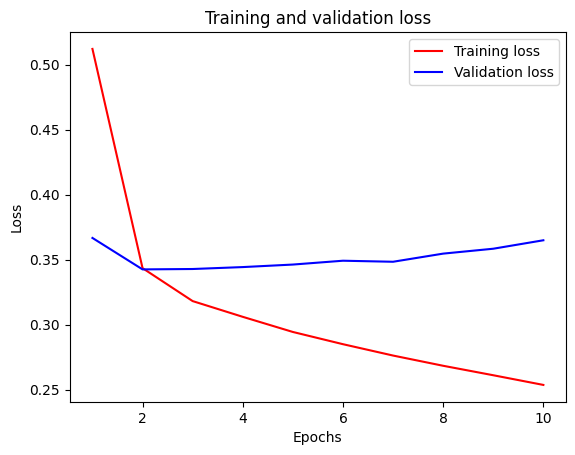

In [226]:
acc_lstm = history_lstm_dict['accuracy']
val_acc_lstm = history_lstm_dict['val_accuracy']
loss_lstm = history_lstm_dict['loss']
val_loss_lstm = history_lstm_dict['val_loss']

epochs_lstm = range(1, len(acc_lstm) + 1)

plt.plot(epochs_lstm, loss_lstm, 'r', label='Training loss')
plt.plot(epochs_lstm, val_loss_lstm, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

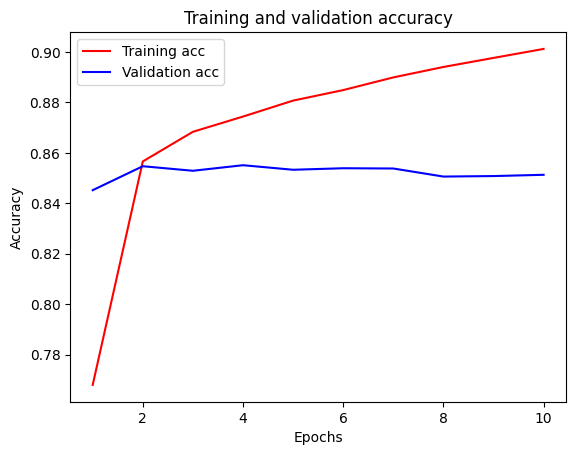

In [227]:
plt.clf()

plt.plot(epochs_lstm, acc_lstm, 'r', label='Training acc')
plt.plot(epochs_lstm, val_acc_lstm, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 6.2. CNN Model Loss, Accuracy 그래프

In [228]:
history_cnn_dict = hustory_cnn.history
print(history_cnn_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


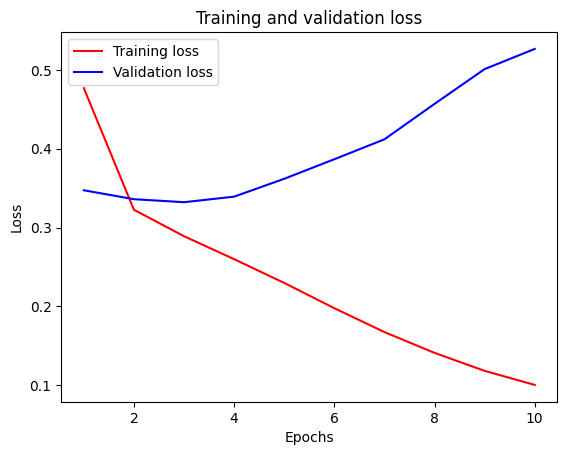

In [229]:
acc_cnn = history_cnn_dict['accuracy']
val_acc_cnn = history_cnn_dict['val_accuracy']
loss_cnn = history_cnn_dict['loss']
val_loss_cnn = history_cnn_dict['val_loss']

epochs_cnn = range(1, len(acc_cnn) + 1)

plt.plot(epochs_cnn, loss_cnn, 'r', label='Training loss')
plt.plot(epochs_cnn, val_loss_cnn, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

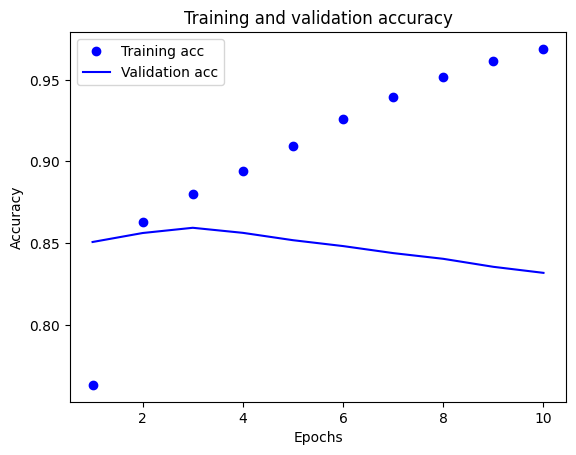

In [230]:
plt.clf()

plt.plot(epochs_cnn, acc_cnn, 'bo', label='Training acc')
plt.plot(epochs_cnn, val_acc_cnn, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 6.3. GMP(?) Model Loss, Accuracy 그래프

In [231]:
history_gmp_dict = history_gmp.history
print(history_gmp_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


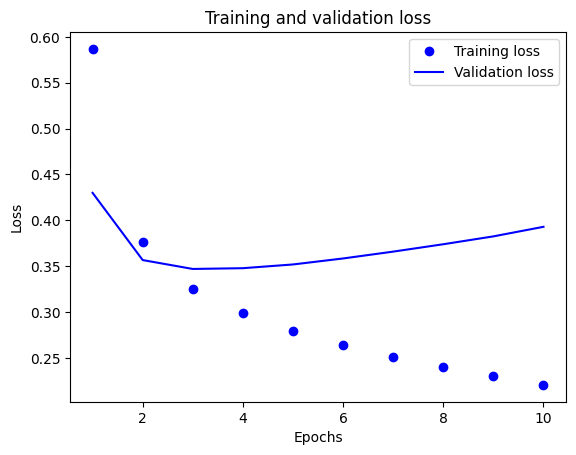

In [232]:
acc_gmp = history_gmp_dict['accuracy']
val_acc_gmp = history_gmp_dict['val_accuracy']
loss_gmp = history_gmp_dict['loss']
val_loss_gmp = history_gmp_dict['val_loss']

epochs_gmp = range(1, len(acc_gmp) + 1)

plt.plot(epochs_gmp, loss_gmp, 'bo', label='Training loss')
plt.plot(epochs_gmp, val_loss_gmp, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

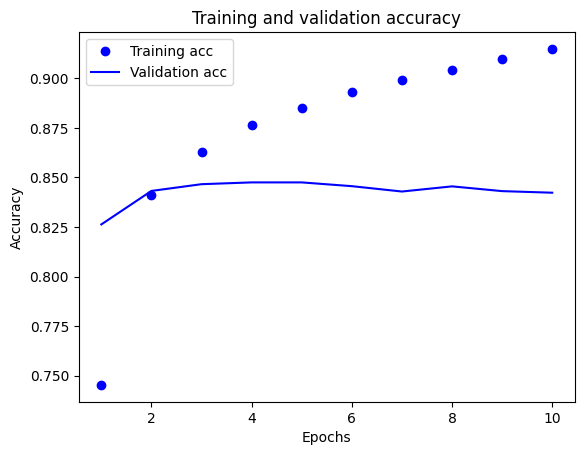

In [233]:
plt.clf()

plt.plot(epochs_gmp, acc_gmp, 'bo', label='Training acc')
plt.plot(epochs_gmp, val_acc_gmp, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

세 모델 모두 accuracy를 정확도가 높지도 않은 상태인데 오버피팅마저 발생하고 있다.  
모델을 더 복잡하게 만들면서도 규제를 적용해야 하겠다.


# 7. 학습된 Embedding 레이어 분석

가장 정확도가 높았던 LSTM Model Embedding 레이어 분석.

In [234]:
embedding_layer = model_lstm.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)

(10000, 16)


In [235]:
word2vec_file_path = 'data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size - 4, word_vector_dim))

vectors = model_lstm.get_weights()[0]

for i in range(4, vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, : ])))))
f.close()

embedding layer의 학습된 퍼래머더들을 txt파일에 저장.

In [236]:
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, encoding='cp949', binary=False)
vector = word_vectors['컴퓨터']
vector

array([ 0.23937039,  0.03366238,  0.03842146, -0.13385805, -0.00873902,
        0.07509922,  0.00273135,  0.01901034, -0.01667288, -0.05788379,
       -0.2328094 ,  0.02061916,  0.00653053, -0.02942078,  0.17892234,
        0.04981962], dtype=float32)

'컴퓨터'라는 단어를 임베딩 레이어에 넣었을 때 출력되는 값.

In [237]:
word_vectors.similar_by_word("사랑")

[('미소', 0.9803286790847778),
 ('소름', 0.9699195027351379),
 ('이민정', 0.967185914516449),
 ('감수성', 0.9663164615631104),
 ('보너스', 0.9654918313026428),
 ('애교', 0.9652990102767944),
 ('잠기', 0.9643710255622864),
 ('소장', 0.9641450643539429),
 ('일품', 0.9625588655471802),
 ('디테일', 0.9614966511726379)]

사랑과 가장 유사하다고 생각되는 10개의 단어들 불러오기.  
하지만 모델이 형편없어서 유사한 단어들을 제대로 추출하지 못하는 것  같다.

# 8. 한국어 Word2Vec 임베딩 활용하여 성능 개선

사전학습된 word2vec_ko 임베딩을 불러와보자.

In [238]:
word2vec_file_path = 'data/word2vec_ko.model'
word_vectors = Word2VecKeyedVectors.load(word2vec_file_path)
vector = word_vectors.wv['끝']
vector

array([ 1.038851  , -1.1634965 ,  2.2386286 ,  0.8971453 , -2.088168  ,
       -4.1942534 , -0.02519768, -0.69813883, -0.2908033 , -1.4651134 ,
       -2.6863668 ,  0.7999443 , -0.6957915 , -0.5018775 ,  3.5025773 ,
        0.21326113, -0.6588098 , -1.1900496 ,  0.61399573,  2.1247969 ,
        0.1549463 ,  3.0840218 ,  3.1680267 , -3.9143991 ,  3.6073153 ,
        0.5315545 , -0.3511633 , -1.107248  ,  1.7767181 , -0.95981866,
        2.6072454 , -0.00697957, -3.27628   ,  1.558644  ,  0.81922376,
        1.9231955 ,  3.7026553 , -0.53824735, -0.4920138 ,  2.4657123 ,
       -2.620749  , -0.08950733,  0.61453176,  1.8866426 ,  0.257866  ,
       -2.7827141 ,  2.9129577 , -0.6313133 ,  2.0387425 , -4.222685  ,
       -2.7560544 ,  1.7903243 , -1.3080189 , -2.5531402 , -0.43849912,
       -3.1073573 , -0.29090825,  5.1817617 ,  1.9604833 , -5.1421604 ,
       -0.71431434,  4.5624633 , -0.55525815, -3.3019137 ,  1.6761336 ,
       -1.9606539 , -0.2726863 ,  0.2465995 ,  1.2685091 ,  1.60

In [239]:
word_vectors.wv.similar_by_word("사랑")

[('이별', 0.7626414895057678),
 ('행복', 0.7550068497657776),
 ('슬픔', 0.7381505966186523),
 ('유혹', 0.7238055467605591),
 ('그리움', 0.7167419195175171),
 ('추억', 0.7143999338150024),
 ('꿈', 0.7089294195175171),
 ('애정', 0.7066588997840881),
 ('포옹', 0.7034594416618347),
 ('마음', 0.6972615718841553)]

자체학습한 임베딩보다 딱봐도 훨씬 더 잘 유사한 단어를 잘 찾는 모습.(이민정은 뭐지?)

[('미소', 0.9803286790847778),  
 ('소름', 0.9699195027351379),  
 ('이민정', 0.967185914516449),  
 ('감수성', 0.9663164615631104),  
 ('보너스', 0.9654918313026428),  
 ('애교', 0.9652990102767944),  
 ('잠기', 0.9643710255622864),  
 ('소장', 0.9641450643539429),  
 ('일품', 0.9625588655471802),  
 ('디테일', 0.9614966511726379)]


In [240]:
word_vector_dim = 100
embedding_matrix = np.random.rand(vocab_size, word_vector_dim)

for i in range(4, vocab_size):
    if index_to_word[i] in word_vectors.wv:
        embedding_matrix[i] = word_vectors.wv[index_to_word[i]]

ndarray에 word2vec 워드 벡터를 단어 하나씩마다 카피.

In [241]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, 
                                 word_vector_dim, 
                                 embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                 input_length=maxlen, 
                                 trainable=True))
                                 
model.add(tf.keras.layers.LSTM(8))
model.add(tf.keras.layers.Dense(4, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_31"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_31 (Embedding)    (None, 41, 100)           1000000   
                                                                 
 lstm_17 (LSTM)              (None, 8)                 3488      
                                                                 
 dense_56 (Dense)            (None, 4)                 36        
                                                                 
 dense_57 (Dense)            (None, 1)                 5         
                                                                 
Total params: 1,003,529
Trainable params: 1,003,529
Non-trainable params: 0
_________________________________________________________________


위에서 카피한 embedding matrix를 embedding 레이어에 삽입.

In [242]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=10

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/10
266/266 [==============================] - 21s 70ms/step - loss: 0.5789 - accuracy: 0.6897 - val_loss: 0.4538 - val_accuracy: 0.7917
Epoch 2/10
266/266 [==============================] - 18s 69ms/step - loss: 0.4154 - accuracy: 0.8141 - val_loss: 0.3815 - val_accuracy: 0.8296
Epoch 3/10
266/266 [==============================] - 18s 69ms/step - loss: 0.3648 - accuracy: 0.8436 - val_loss: 0.3594 - val_accuracy: 0.8409
Epoch 4/10
266/266 [==============================] - 18s 66ms/step - loss: 0.3385 - accuracy: 0.8568 - val_loss: 0.3539 - val_accuracy: 0.8438
Epoch 5/10
266/266 [==============================] - 18s 68ms/step - loss: 0.3211 - accuracy: 0.8657 - val_loss: 0.3502 - val_accuracy: 0.8488
Epoch 6/10
266/266 [==============================] - 18s 66ms/step - loss: 0.3081 - accuracy: 0.8721 - val_loss: 0.3507 - val_accuracy: 0.8465
Epoch 7/10
266/266 [==============================] - 18s 70ms/step - loss: 0.2981 - accuracy: 0.8775 - val_loss: 0.3497 - val_accuracy:

In [243]:
results = model.evaluate(test_X, test_y, verbose=2)

print(results)

1537/1537 - 7s - loss: 0.3689 - accuracy: 0.8436 - 7s/epoch - 5ms/step
[0.3688688278198242, 0.8436235189437866]


word2vec 임베딩을 사용해도 accuracy는 거의 차이가 없었다.

In [244]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


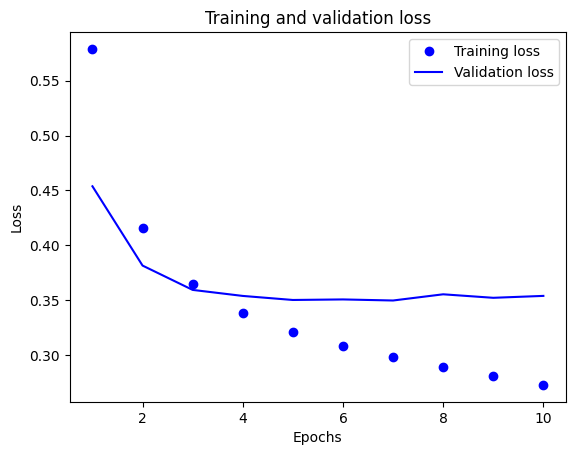

In [245]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

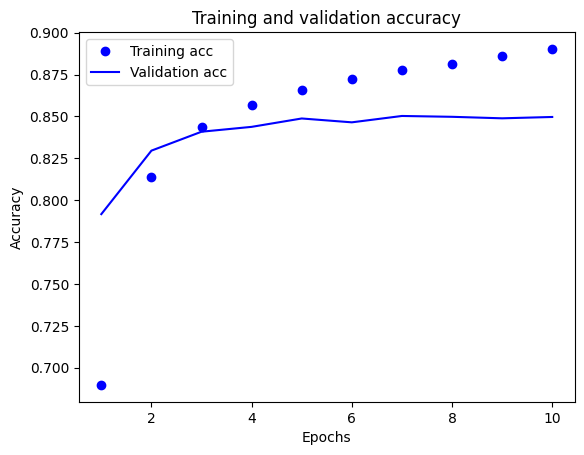

In [246]:
plt.clf()

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

lstm과 dense의 차원수가 낮아서 성능이 제대로 안나온 것 같고  
batch size와 epoch가 높아서 일반화 성능이 낮은 것 같으므로  
조치를 취한 최종 모델을 학습한다.

# 9. 최종 모델 학습 및 평가

In [247]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size,
                                 word_vector_dim,
                                 embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix),
                                 input_length=maxlen,
                                 trainable=True))
                                 
model.add(tf.keras.layers.LSTM(64))
model.add(tf.keras.layers.Dense(8, activation='relu'))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential_32"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_32 (Embedding)    (None, 41, 100)           1000000   
                                                                 
 lstm_18 (LSTM)              (None, 64)                42240     
                                                                 
 dense_58 (Dense)            (None, 8)                 520       
                                                                 
 dense_59 (Dense)            (None, 1)                 9         
                                                                 
Total params: 1,042,769
Trainable params: 1,042,769
Non-trainable params: 0
_________________________________________________________________


In [248]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=5

history = model.fit(X_train,
                    y_train,
                    epochs=epochs,
                    batch_size=32,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/5
4256/4256 [==============================] - 218s 51ms/step - loss: 0.3951 - accuracy: 0.8181 - val_loss: 0.3366 - val_accuracy: 0.8493
Epoch 2/5
4256/4256 [==============================] - 199s 47ms/step - loss: 0.3031 - accuracy: 0.8703 - val_loss: 0.3115 - val_accuracy: 0.8645
Epoch 3/5
4256/4256 [==============================] - 198s 46ms/step - loss: 0.2686 - accuracy: 0.8880 - val_loss: 0.3127 - val_accuracy: 0.8695
Epoch 4/5
4256/4256 [==============================] - 196s 46ms/step - loss: 0.2410 - accuracy: 0.9010 - val_loss: 0.3132 - val_accuracy: 0.8670
Epoch 5/5
4256/4256 [==============================] - 189s 44ms/step - loss: 0.2151 - accuracy: 0.9131 - val_loss: 0.3233 - val_accuracy: 0.8655


accuracy와 val_accuracy가 차이가 좀 나서 오버피팅이 의심스럽지만  
우선 테스트 데이터 셋 평가로 넘어가보자.

In [249]:
results = model.evaluate(test_X, test_y, verbose=2)

print(results)

1537/1537 - 19s - loss: 0.3337 - accuracy: 0.8617 - 19s/epoch - 12ms/step
[0.3337443172931671, 0.8617287278175354]


정확도를 85%를 넘기는 모습이다.

# 10. 회고하기

## 10.1. 이번 프로젝트에서 어려웠던 점

로컬에서 Mecab 함수를 불러오는 것이 가장 어려웠다.  
주말에 편의점 알바를 하며 노트북으로 구글링해서 겨우겨우 해결하였다.  
그래도 덕분에 가상환경 설정 및 pip와 conda의 차이등을 알 수 있어서 좋았다.

## 10.2. 프로젝트를 진행하면서 알아낸 점 혹은 아직 모호한 점

CNN 모델을 이용해서 NLP 분석을 할 수 있다는 것이 신기했다.  
CV와 NLP의 경계가 모호해 진다는 게 이것인건가?  
다만 아직 LSTM이 내부적으로 어떻게 돌아가는지는 정확히 알지는 못했다.

## 10.3. 루브릭 평가 지표를 맞추기 위해 시도한 것들

노드를 따라가다보면 평가문항 1, 2번은 자연스레 달성이 되는데  
3번 문항의 정확도 85% 달성 미션은 모델을 조금 수정해야 달성할 수 있었다.  
LSTM의 dim이 8로 아주 낮길래 64로 올렸고 Dense의 dim을 8로 올렸더니 달성되었다.

## 10.4. 만약에 루브릭 평가 관련 지표를 달성 하지 못했을 때, 이유에 관한 추정

루브릭 평가 지표를 달성하기는 쉬웠지만 나처럼 로컬에서 프로젝트를 진행했으면  
환경 설정에만 아주 많은 시간을 할당하느라 프로젝트 제출을 못햇을 수도 있다.

## 10.5. 회상 혹은 자기 다짐

다른 그루들의 프로젝트와 비교시 나는 너무 딱 하라는 것만 하는 편인 것 같다.  
그래서 별점은 높지만 뭔가 텅빈듯한 느낌이다.  
사실 예전부터 뭐든지 느릿하게 하는 편이라 프로젝트에서 해보고 싶은 것들을 해보기는 커녕  
진도 따라가기도 벅찬 상황이다.  
블로그를 하루 빨리 시작해서 구글링하는 시간을 조금이라도 단축시켜야겠다.